In [1]:
import requests
import json
from newsapi.newsapi_client import NewsApiClient
import pandas as pd
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import requests
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Obtendo noticias

In [67]:
from newsapi import NewsApiClient

# Inicialize o cliente NewsApiClient com a sua chave de API
api_key = '3be6fb74511c432bb6741415eb0419d7'
newsapi = NewsApiClient(api_key=api_key)

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('vader_lexicon')

def get_bitcoin_news(newsapi, from_date, to_date, page_size=100, page=1):
    # Coletando notícias usando a API NewsApiClient
    all_articles = newsapi.get_everything(
        q='bitcoin',
        from_param=from_date,
        to=to_date,
        language='pt',
        sort_by='relevancy',
        page_size=page_size,
        page=page
    )
    return all_articles['articles']

# Coletando as notícias entre 2024-11-10 e 2024-12-06
from_date = '2024-11-20'
to_date = '2024-12-10'
news = get_bitcoin_news(newsapi, from_date, to_date)

# Exibindo as 5 primeiras notícias para garantir que os dados foram coletados
for i, article in enumerate(news[:5]):
    print(f"Notícia {i+1}: {article['title']}")
    print(f"Fonte: {article['source']['name']}")
    print(f"Data de Publicação: {article['publishedAt']}")
    print(f"Resumo: {article['description']}")
    print(f"URL: {article['url']}\n")


[nltk_data] Downloading package punkt to /home/ayres/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ayres/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ayres/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ayres/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Notícia 1: O que está acontecendo com o preço do bitcoin?
Fonte: Olhardigital.com.br
Data de Publicação: 2024-11-24T22:20:00Z
Resumo: O preço do bitcoin foi impactado pela eleição de Donald Trump nos Estados Unidos, com a esperança de um mandato pró-cripto.
O post O que está acontecendo com o preço do bitcoin? apareceu primeiro em Olhar Digital.
URL: https://olhardigital.com.br/2024/11/24/pro/o-que-esta-acontecendo-com-o-preco-do-bitcoin/

Notícia 2: Bitcoin supera US$ 100 mil pela primeira vez em sua história
Fonte: Olhardigital.com.br
Data de Publicação: 2024-12-05T12:03:00Z
Resumo: Entre os fatores que levaram o Bitcoin a ultrapassar US$ 100 mil, está a vitória de Donald Trump nas eleições presidenciais dos EUA
O post Bitcoin supera US$ 100 mil pela primeira vez em sua história apareceu primeiro em Olhar Digital.
URL: https://olhardigital.com.br/2024/12/05/pro/bitcoin-supera-us-100-mil-pela-primeira-vez-em-sua-historia/

Notícia 3: Bitcoin atinge valor recorde de US$ 100 mil pela pr

## Obtendo preços do bitcoin

In [68]:

# Endpoint da API CoinGecko para pegar preços históricos do Bitcoin
url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart'

# Parâmetros da requisição: período e moeda
params = {
    'vs_currency': 'brl',  # Moeda que estamos interessados, USD
    'days': '20',  # Últimos 30 dias de dados
    'interval': 'daily'  # Intervalo de dados diário
}

# Realizando a requisição GET
response = requests.get(url, params=params)

# Verificando se a requisição foi bem-sucedida
if response.status_code == 200:
    # Convertendo a resposta JSON para um dicionário
    data = response.json()
    
    # Extraindo os preços e as datas
    prices = data['prices']
    prices_df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    
    # Convertendo a coluna de timestamps para datetime
    prices_df['date'] = pd.to_datetime(prices_df['timestamp'], unit='ms')
    
    # Remover a coluna de timestamp
    prices_df = prices_df.drop(columns=['timestamp'])
    
    # Exibindo os preços coletados
    print(prices_df)
else:
    print("Erro ao acessar a API:", response.status_code)



            price                date
0   572820.575186 2024-11-22 00:00:00
1   573878.398179 2024-11-23 00:00:00
2   566638.569599 2024-11-24 00:00:00
3   568544.962609 2024-11-25 00:00:00
4   539405.130281 2024-11-26 00:00:00
5   534077.970875 2024-11-27 00:00:00
6   570022.633300 2024-11-28 00:00:00
7   575442.764327 2024-11-29 00:00:00
8   582175.954315 2024-11-30 00:00:00
9   576559.861067 2024-12-01 00:00:00
10  581341.695745 2024-12-02 00:00:00
11  580595.472536 2024-12-03 00:00:00
12  580530.415586 2024-12-04 00:00:00
13  597273.739956 2024-12-05 00:00:00
14  584346.259739 2024-12-06 00:00:00
15  608820.760905 2024-12-07 00:00:00
16  607651.388285 2024-12-08 00:00:00
17  616568.767115 2024-12-09 00:00:00
18  591902.262415 2024-12-10 00:00:00
19  584257.188929 2024-12-11 00:00:00
20  583642.195715 2024-12-11 01:40:20


## Pré-processamento noticias

In [69]:
# Função de limpeza de texto
def clean_text(text):
    # Remover URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remover caracteres especiais e pontuação
    #text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Converter para minúsculas
    text = text.lower()
    
    return text

# Função para remover stopwords e tokenizar
def tokenize_and_remove_stopwords(text):
    # Tokenizar o texto
    tokens = word_tokenize(text)
    
    # Remover stopwords
    stop_words = set(stopwords.words('portuguese'))  # Usar stopwords em português
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return " ".join(filtered_tokens)

# Pré-processar as notícias coletadas
cleaned_news = [clean_text(article['description']) for article in news if article['description']]
tokenized_news = [tokenize_and_remove_stopwords(article) for article in cleaned_news]

# Exibir as notícias processadas
print("Notícias após pré-processamento:")
for article in tokenized_news[:5]:  # Exibir as 5 primeiras notícias processadas
    print(article)

# Usando o TF-IDF para converter o texto em vetores numéricos
vectorizer = TfidfVectorizer(max_features=100)  # Usando as 100 palavras mais importantes
X = vectorizer.fit_transform(tokenized_news)

# Exibindo a representação TF-IDF
print("\nMatriz TF-IDF:")
print(X.toarray())


Notícias após pré-processamento:
preço bitcoin impactado eleição donald trump estados unidos , esperança mandato pró-cripto . post acontecendo preço bitcoin ? apareceu primeiro olhar digital .
fatores levaram bitcoin ultrapassar us $ 100 mil , vitória donald trump eleições presidenciais eua post bitcoin supera us $ 100 mil primeira vez história apareceu primeiro olhar digital .
bitcoin atingiu última quarta-feira ( 04 ) maior valor história cotação dólar . primeira vez desde criação , unidade criptomoeda vale us $ 100 mil — aproximadamente r $ 603 mil conversão direta moeda.ao tod…
sim , leu bem ! apenas bitcoin vale agora quase 92 mil euros . últimos tempos criptomoeda valorizado bastante , fale nova criptomoedas . bitcoin chegou ...
entusiastas aguardavam , quinta-feira , bitcoin passou 100 mil dólares , marco significativamente importante mercado criptomoeda . bitcoin além 100 mil dólares . maior criptomoeda ...

Matriz TF-IDF:
[[0.         0.         0.         ... 0.         0.   

## Pré-processamento bitcoin

Preços originais:
                    price
date                     
2024-11-22  572820.575186
2024-11-23  573878.398179
2024-11-24  566638.569599
2024-11-25  568544.962609
2024-11-26  539405.130281

Verificando valores nulos:
price    0
dtype: int64

Dados NaN:
price                 0
daily_return          1
price_change          1
7_day_moving_avg      6
20_day_moving_avg    19
dtype: int64

Dados após criação de novas colunas:
                             price  daily_return  price_change  \
date                                                             
2024-12-08 00:00:00  607651.388285     -0.001921  -1169.372620   
2024-12-09 00:00:00  616568.767115      0.014675   8917.378830   
2024-12-10 00:00:00  591902.262415     -0.040006 -24666.504700   
2024-12-11 00:00:00  584257.188929     -0.012916  -7645.073486   
2024-12-11 01:40:20  583642.195715     -0.001053   -614.993214   

                     7_day_moving_avg  20_day_moving_avg  
date                                       

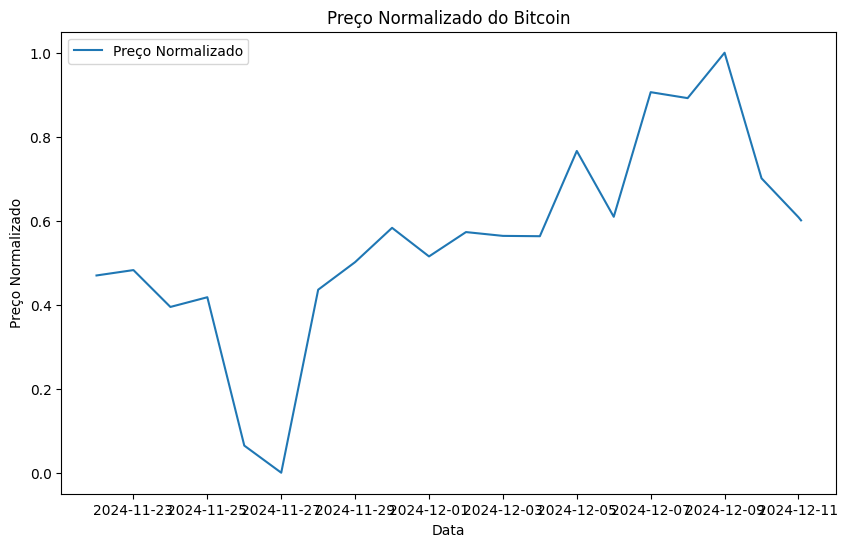


Dados normalizados:
                        price  daily_return  price_change  7_day_moving_avg  \
date                                                                          
2024-11-22 00:00:00  0.469660           NaN           NaN               NaN   
2024-11-23 00:00:00  0.482483      0.447891   1057.822993               NaN   
2024-11-24 00:00:00  0.394718      0.325904  -7239.828580               NaN   
2024-11-25 00:00:00  0.417828      0.460693   1906.393010               NaN   
2024-11-26 00:00:00  0.064579      0.000000 -29139.832328               NaN   
2024-11-27 00:00:00  0.000000      0.349012  -5327.159406               NaN   
2024-11-28 00:00:00  0.435741      1.000000  35944.662424          0.000000   
2024-11-29 00:00:00  0.501447      0.512519   5420.131027          0.009879   
2024-11-30 00:00:00  0.583071      0.531010   6733.189988          0.041140   
2024-12-01 00:00:00  0.514989      0.350946  -5616.093248          0.078517   
2024-12-02 00:00:00  0.572958  

In [73]:
# Extraindo os preços e as datas
prices = data['prices']

# Criando um DataFrame com as colunas de timestamp e price
prices_df = pd.DataFrame(prices, columns=['timestamp', 'price'])

# Convertendo a coluna de timestamps para datetime
prices_df['date'] = pd.to_datetime(prices_df['timestamp'], unit='ms')

# Remover a coluna de timestamp
prices_df = prices_df.drop(columns=['timestamp'])

# Definir a coluna 'date' como índice
prices_df.set_index('date', inplace=True)
# Exibindo os preços coletados
print("Preços originais:")
print(prices_df.head())
# 1. Limpeza dos dados
# Verificar valores nulos
print("\nVerificando valores nulos:")
print(prices_df.isnull().sum())
# Se houver valores nulos, podemos preenchê-los ou descartá-los
prices_df.fillna(0, inplace=True)  # Preenche valores nulos com zero

# 2. Criação de novas colunas
# Calcular o retorno diário
prices_df['daily_return'] = prices_df['price'].pct_change()

prices_df['price_change'] = prices_df['price'].diff()

# Calcular a média móvel de 7 dias
prices_df['7_day_moving_avg'] = prices_df['price'].rolling(window=7).mean()

# Calcular a média móvel de 30 dias
prices_df['20_day_moving_avg'] = prices_df['price'].rolling(window=20).mean()
print("\nDados NaN:")
print(prices_df.isnull().sum())
# Exibindo as novas colunas
print("\nDados após criação de novas colunas:")
print(prices_df.tail())
print("\nDados NaN:")
print(prices_df.isnull().sum())
# 3. Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))  # Escalando entre 0 e 1
prices_df[['price', 'daily_return', '7_day_moving_avg', '20_day_moving_avg']] = scaler.fit_transform(
    prices_df[['price', 'daily_return', '7_day_moving_avg', '20_day_moving_avg']]
)

# 4. Visualização dos preços normalizados
plt.figure(figsize=(10, 6))
plt.plot(prices_df['price'], label='Preço Normalizado')
plt.title('Preço Normalizado do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço Normalizado')
plt.legend()
plt.show()
    
# Exibindo os dados processados
print("\nDados normalizados:")
print(prices_df)

## Treinamento do Modelo de Análise de Sentimentos

In [ ]:
# Função para calcular o sentimento das notícias usando VADER
def get_sentiment_label(score):
    if score > 0.1: #0.1
        return 'Positivo'
    elif score < -0.1: #-0.1
        return 'Negativo'
    else:
        return 'Neutro'

def get_sentiment_scores(news_articles):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_labels = []
    sentiment_scores = []
    
    for article in news_articles:
        # Calcula o sentimento de cada notícia
        sentiment = analyzer.polarity_scores(article['description'])
        score = sentiment['compound']  # 'compound' é o score geral do sentimento
        
        # Classificar como 'Positivo', 'Negativo' ou 'Neutro'
        sentiment_labels.append(get_sentiment_label(score))
        sentiment_scores.append(score)  # Salva o valor numérico do sentimento
        
        
    return sentiment_labels, sentiment_scores

# Calculando o sentimento das notícias
sentiment_labels, sentiment_scores = get_sentiment_scores(news)

dates_news = [article['publishedAt'][:10] for article in news]  # Extrai apenas a data (ano-mês-dia)

# Convertendo as datas das notícias para o formato datetime
dates_news = pd.to_datetime(dates_news)

# Criando o DataFrame de sentimentos das notícias
news_df = pd.DataFrame({
    'date': dates_news,
    'sentiment_label': sentiment_labels,
    'sentiment_score': sentiment_scores
})

# Agora vamos adicionar esses dados ao DataFrame prices_df
# Certifique-se de que a coluna 'date' no prices_df esteja no formato datetime
prices_df['date'] = prices_df.index  # A coluna de data é o índice no prices_df

# Fazendo o merge dos sentimentos com o DataFrame de preços
# Vamos associar os sentimentos à data mais próxima
prices_df['sentiment_label'] = prices_df['date'].apply(
    lambda x: news_df.loc[(news_df['date'] - x).abs().idxmin(), 'sentiment_label']
)

prices_df['sentiment_score'] = prices_df['date'].apply(
    lambda x: news_df.loc[(news_df['date'] - x).abs().idxmin(), 'sentiment_score']
)

# Agora o DataFrame prices_df tem as colunas 'sentiment_label' e 'sentiment_score'
# Exibindo os primeiros dados para verificar
print(prices_df.head())



               price  daily_return  price_change  7_day_moving_avg  \
date                                                                 
2024-11-12  0.037596           NaN           NaN               NaN   
2024-11-13  0.012009      0.385602  -2825.926358               NaN   
2024-11-14  0.174783      0.731136  17977.455525               NaN   
2024-11-15  0.000000      0.122425 -19303.830631               NaN   
2024-11-16  0.191014      0.783899  21096.402471               NaN   

            30_day_moving_avg       date sentiment_label  sentiment_score  \
date                                                                        
2024-11-12                NaN 2024-11-12        Negativo          -0.2960   
2024-11-13                NaN 2024-11-13        Negativo           0.0000   
2024-11-14                NaN 2024-11-14        Negativo           0.0000   
2024-11-15                NaN 2024-11-15        Negativo          -0.5267   
2024-11-16                NaN 2024-11-16       

## Treinamento do Modelo para Analisar o Impacto no Preço do Bitcoin

Erro Médio Quadrático (MSE) do ARIMA: 390504442.19555044


/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


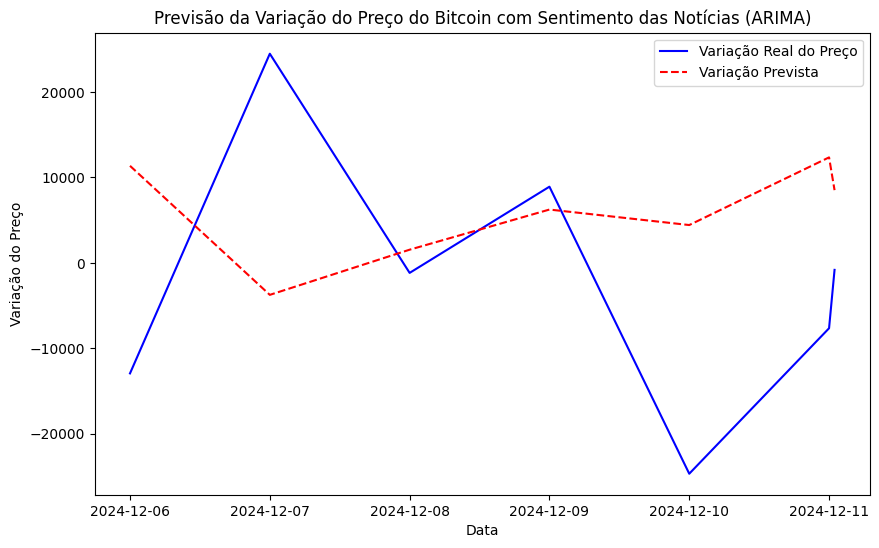

In [55]:
# Dividindo os dados em treino e teste
train_size = int(len(prices_df) * 0.8)
train, test = prices_df[:train_size], prices_df[train_size:]

# Criando o modelo ARIMA
model = ARIMA(train['price_change'], exog=train['sentiment_score'], order=(5, 1, 0))  # ARIMA(p,d,q)
model_fit = model.fit()

# Fazendo previsões
forecast = model_fit.forecast(steps=len(test), exog=test['sentiment_score'])

# Calculando o erro médio quadrático (MSE)
mse = mean_squared_error(test['price_change'], forecast)
print(f"Erro Médio Quadrático (MSE) do ARIMA: {mse}")

# Visualizando as previsões
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['price_change'], label='Variação Real do Preço', color='blue')
plt.plot(test.index, forecast, label='Variação Prevista', color='red', linestyle='--')
plt.title('Previsão da Variação do Preço do Bitcoin com Sentimento das Notícias (ARIMA)')
plt.xlabel('Data')
plt.ylabel('Variação do Preço')
plt.legend()
plt.show()


In [ ]:
# # Dividindo os dados em treino e teste
# train_size = int(len(prices_df) * 0.8)
# train, test = prices_df[:train_size], prices_df[train_size:]

# # Criando o modelo ARIMA
# model = ARIMA(train['price_change'], exog=train['sentiment'], order=(5, 1, 0))  # ARIMA(p,d,q)
# model_fit = model.fit()

# # Fazendo previsões
# forecast = model_fit.forecast(steps=len(test), exog=test['sentiment'])

# # Calculando o erro médio quadrático (MSE)
# mse = mean_squared_error(test['price_change'], forecast)
# print(f"Erro Médio Quadrático (MSE) do ARIMA: {mse}")

# # Visualizando as previsões
# plt.figure(figsize=(10, 6))
# plt.plot(test.index, test['price_change'], label='Variação Real do Preço', color='blue')
# plt.plot(test.index, forecast, label='Variação Prevista', color='red', linestyle='--')
# plt.title('Previsão da Variação do Preço do Bitcoin com Sentimento das Notícias (ARIMA)')
# plt.xlabel('Data')
# plt.ylabel('Variação do Preço')
# plt.legend()
# plt.show()

## Avaliação e Ajustes no Modelo

In [50]:
# Exemplo de labels reais (baseado em um método simplificado)
# Aqui estamos criando 5 rótulos reais como exemplo
sentiment_labels_true = ['Positivo', 'Neutro', 'Negativo', 'Positivo', 'Neutro']  # Ajuste com seus dados reais

# Vamos assumir que você já tem as predições (exemplo de 5 predições, correspondendo a 5 notícias)
sentiment_labels = ['Positivo', 'Neutro', 'Negativo', 'Positivo', 'Neutro']  # Exemplo de predições feitas pelo modelo

# Caso tenha mais predições que rótulos reais, é necessário ajustar a lista
# Aqui vamos simular 100 predições para ilustrar o erro

sentiment_labels = ['Positivo'] * 100  # Exemplo onde temos 100 predições de 'Positivo'

# Para ajustar isso, considere uma abordagem para limitar ou expandir a lista de predições
# Aqui vamos simplificar limitando as predições para 5, para que fiquem consistentes com os rótulos reais

sentiment_labels = sentiment_labels[:5]  # Ajusta para que o número de predições seja o mesmo

# Agora, calculamos as métricas com dados consistentes
accuracy = accuracy_score(sentiment_labels_true, sentiment_labels)
precision = precision_score(sentiment_labels_true, sentiment_labels, average='macro', labels=['Positivo', 'Negativo', 'Neutro'])
recall = recall_score(sentiment_labels_true, sentiment_labels, average='macro', labels=['Positivo', 'Negativo', 'Neutro'])
f1 = f1_score(sentiment_labels_true, sentiment_labels, average='macro', labels=['Positivo', 'Negativo', 'Neutro'])

# Exibindo as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Acurácia: 0.4000
Precisão: 0.1333
Recall: 0.3333
F1-score: 0.1905


/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
# Fazendo previsões com o modelo ARIMA
forecast = model_fit.forecast(steps=len(test), exog=test['sentiment_score'])

# Calculando o erro absoluto médio (MAE) e erro quadrático médio (RMSE)
mae = mean_absolute_error(test['price_change'], forecast)
rmse = np.sqrt(mean_squared_error(test['price_change'], forecast))

# Exibindo as métricas
print(f"Erro Absoluto Médio (MAE): {mae:.4f}")
print(f"Erro Quadrático Médio (RMSE): {rmse:.4f}")


Erro Absoluto Médio (MAE): 16614.8415
Erro Quadrático Médio (RMSE): 19761.1852


In [40]:
# Verificando a correlação entre price_change e sentiment
print(prices_df[['price_change', 'sentiment_score']].corr())


                 price_change  sentiment_score
price_change         1.000000        -0.049297
sentiment_score     -0.049297         1.000000


In [52]:
from sklearn.preprocessing import StandardScaler

# Normalizando as variáveis
scaler = StandardScaler()

# Aplicando a normalização na variável 'sentiment'
prices_df['sentiment_scaled'] = scaler.fit_transform(prices_df[['sentiment_score']])


/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All p

MAE: 13809.3775, RMSE: 15037.7602
MAE: 16986.9160, RMSE: 18991.3295


/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 

MAE: 15070.3422, RMSE: 15633.5752
MAE: 21272.2116, RMSE: 24090.9738
MAE: 11754.9648, RMSE: 15729.7836


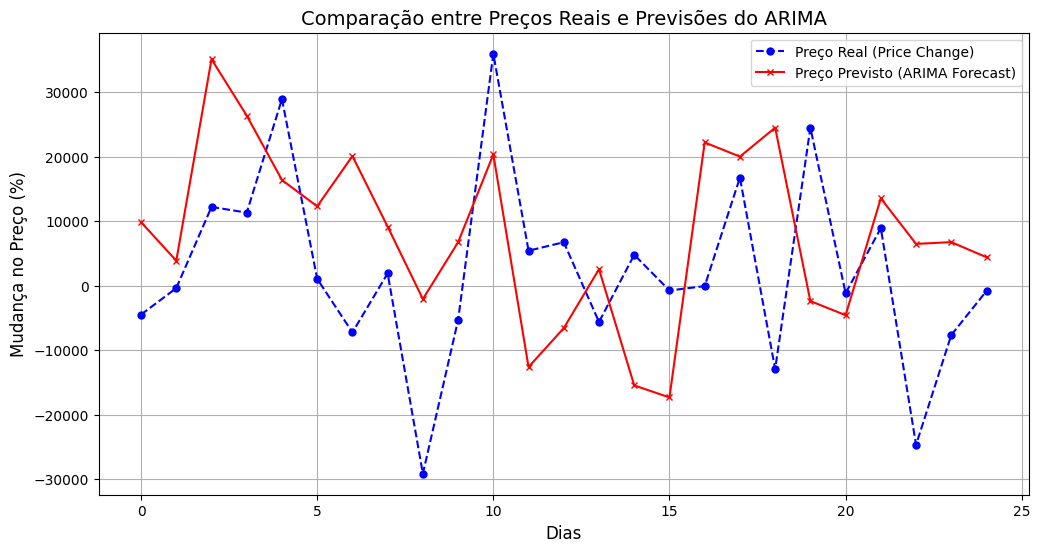

Métricas de Análise de Sentimentos:
Acurácia: 0.4000
Precisão: 0.1333
Recall: 0.3333
F1-score: 0.1905


/home/ayres/Documents/estudos/pos-tech-fiap-tech-challenge-3/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [53]:
# Normalizando a variável 'sentiment'
scaler = StandardScaler()
prices_df['sentiment_scaled'] = scaler.fit_transform(prices_df[['sentiment_score']])

# Definindo o número de splits para validação cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando listas para armazenar os resultados
forecasted_prices = []
true_prices = []

# Realizando a validação cruzada
for train_index, test_index in tscv.split(prices_df):
    train, test = prices_df.iloc[train_index], prices_df.iloc[test_index]
    
    # Criando o modelo ARIMA (ajustando os parâmetros conforme necessário)
    try:
        model = ARIMA(train['price_change'], exog=train['sentiment_scaled'], order=(5, 1, 0))
        model_fit = model.fit()
    
        # Fazendo previsões
        forecast = model_fit.forecast(steps=len(test), exog=test['sentiment_scaled'])
    
        # Calculando os erros
        mae = mean_absolute_error(test['price_change'], forecast)
        rmse = np.sqrt(mean_squared_error(test['price_change'], forecast))
    
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        # Armazenando os resultados para plotagem
        forecasted_prices.extend(forecast)
        true_prices.extend(test['price_change'].values)
    
    except Exception as e:
        print(f"Erro ao ajustar o modelo ARIMA: {e}")


# Plotando o gráfico de comparação entre preços reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Preço Real (Price Change)', color='blue', linestyle='--', marker='o', markersize=5)
plt.plot(forecasted_prices, label='Preço Previsto (ARIMA Forecast)', color='red', linestyle='-', marker='x', markersize=5)

# Personalizando o gráfico
plt.title('Comparação entre Preços Reais e Previsões do ARIMA', fontsize=14)
plt.xlabel('Dias', fontsize=12)
plt.ylabel('Mudança no Preço (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Calculando as métricas de sentimentos
accuracy = accuracy_score(sentiment_labels_true, sentiment_labels)
precision = precision_score(sentiment_labels_true, sentiment_labels, average='macro', labels=['Positivo', 'Negativo', 'Neutro'])
recall = recall_score(sentiment_labels_true, sentiment_labels, average='macro', labels=['Positivo', 'Negativo', 'Neutro'])
f1 = f1_score(sentiment_labels_true, sentiment_labels, average='macro', labels=['Positivo', 'Negativo', 'Neutro'])

# Exibindo as métricas de sentimentos
print(f"Métricas de Análise de Sentimentos:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
